Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [3]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [4]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

In [5]:
clf = RidgeClassifier(alpha=0.0).fit(seven_X, seven_y)
pred_y = clf.predict(seven_X)
accuracy = accuracy_score(seven_y, pred_y)

print(accuracy)

1.0


Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

0.8833333333333332


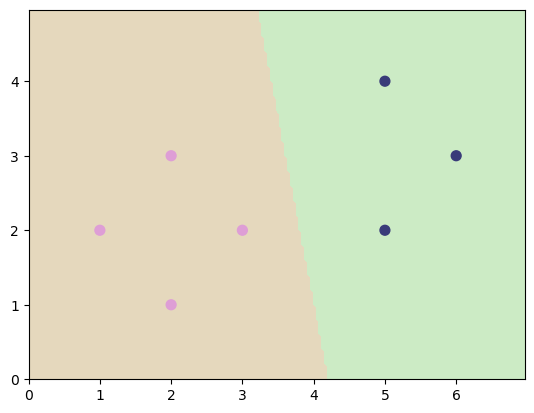

In [6]:
reg = LinearRegression().fit(seven_X, seven_y)
print(reg.score(seven_X, seven_y))

h = lambda x: clf.predict(x) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, h = h)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [7]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

0.875
0.660245183887916


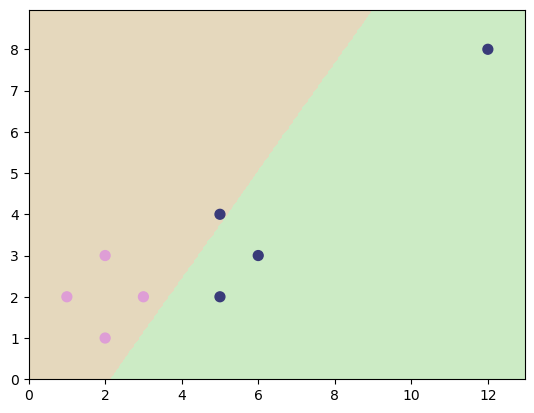

In [8]:
clf = RidgeClassifier(alpha=0.0).fit(outlier_X, outlier_y)
pred_y = clf.predict(outlier_X)
accuracy = accuracy_score(outlier_y, pred_y)
print(accuracy)

reg = LinearRegression().fit(outlier_X, outlier_y)
print(reg.score(outlier_X, outlier_y))

h = lambda x: clf.predict(x) >= 0.5
plot_2d_clf_problem(outlier_X, outlier_y, h = h)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [9]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

0.875
0.5353535353535352


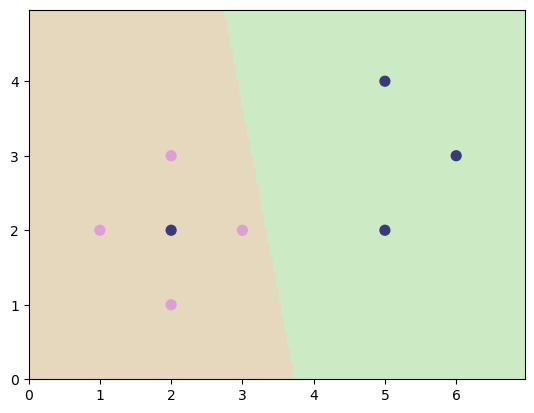

In [10]:
clf = RidgeClassifier(alpha=0.0).fit(unsep_X, unsep_y)
pred_y = clf.predict(unsep_X)
accuracy = accuracy_score(unsep_y, pred_y)
print(accuracy)

reg = LinearRegression().fit(unsep_X, unsep_y)
print(reg.score(unsep_X, unsep_y))

h = lambda x: clf.predict(x) >= 0.5
# h = lambda x: reg.predict(x) >= 0.5
plot_2d_clf_problem(unsep_X, unsep_y, h = h)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

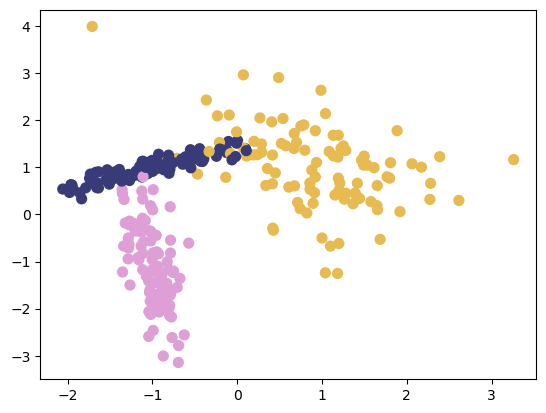

In [44]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=300, n_features=2, n_informative=2, 
                           n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                           random_state=42)

plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

Text(0.5, 1.0, 'Model dobiven sa RidgeClassifier')

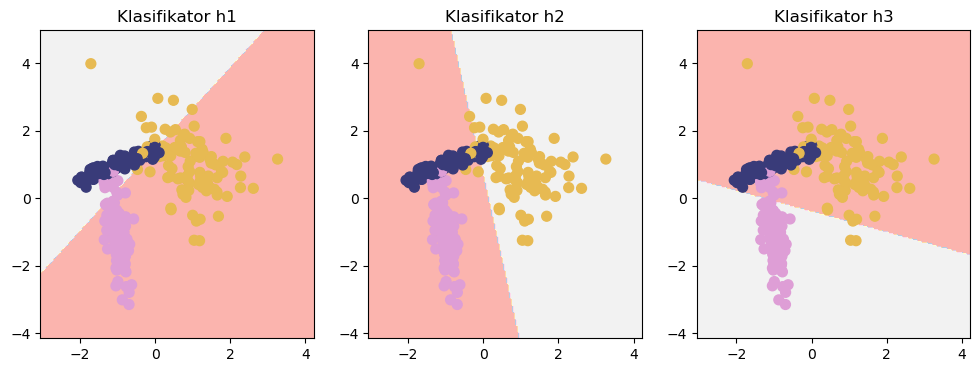

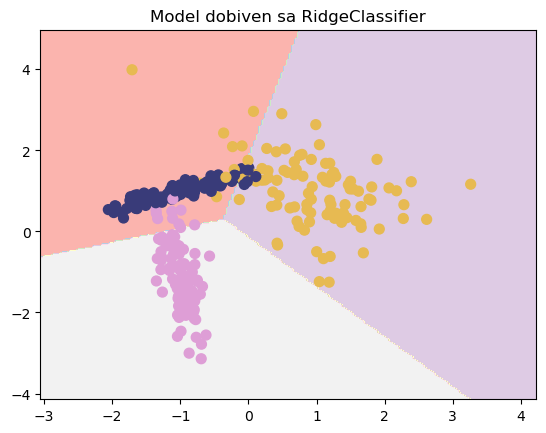

In [12]:
classifiers = []

classifiers.append(RidgeClassifier(alpha=0).fit(X, (y==0).astype(int)))
classifiers.append(RidgeClassifier(alpha=0).fit(X, (y==1).astype(int)))
classifiers.append(RidgeClassifier(alpha=0).fit(X, (y==2).astype(int)))

figure(figsize=(12, 4)) # jer se nis nije lijepo vidlo bez figsize
for i in range(3):
    subplot(1, 3, i + 1)
    plot_2d_clf_problem(X, y, h=classifiers[i].predict)
    title(f"Klasifikator h{i+1}")

def predict(x):
    scores = []
    for i in range (len(classifiers)):
        scores.append(classifiers[i].decision_function(x.reshape(1, -1)))
    return argmax(scores)

figure()
plot_2d_clf_problem(X, y, h=predict)
title("Model dobiven sa RidgeClassifier")

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

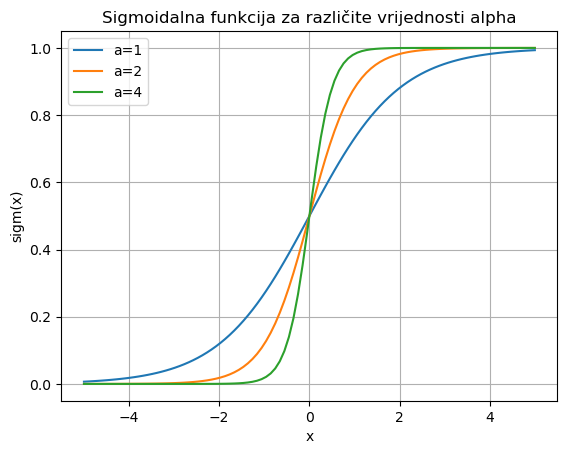

In [13]:
def sigm(x, alpha):
    return 1/(1+exp(-alpha*x))

x = linspace(-5, 5, 100)
alphas = [1, 2, 4]
for alpha in alphas:
    y = sigm(x, alpha)
    plot(x, y, label=f'a={alpha}')

title('Sigmoidalna funkcija za različite vrijednosti alpha')
xlabel('x')
ylabel('sigm(x)')
legend()
grid(True)
show()


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [169]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    errors = []
    n = X.shape[1]
    w = zeros(n)
    if trace:
        weight_trace = [w.copy()]
    for iteration in range(max_iter):
        h = lr_h(X, w)
        gradient = dot(X.T, h - y) / len(y)

        w[0] -= eta * gradient[0]
        w[1:] -= eta * (gradient[1:] + alpha * w[1:])
        
        error = cross_entropy_error(X, y, w, alpha)
        errors.append(error)
        if trace:
            weight_trace.append(w.copy())
        if iteration > 0 and abs(error - prev_error) < epsilon:
            break
        prev_error = error
    
    if trace:
        return w, weight_trace, errors
    else:
        return w

def lr_h(x, w):
    return 1 / (1 + exp(-dot(x, w)))

def cross_entropy_error(X, y, w, alpha=0):
    m = len(y)
    h = lr_h(X, w)
    reg_term = (alpha / (2 * m)) * dot(w[1:], w[1:])
    error = (-1/m) * (dot(y, log(h)) + dot(1 - y, log(1 - h))) + reg_term
    return error

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [170]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Težine modela: [ 9.47713187 -2.33012265 -0.23650719]
Pogreška unakrsne entropije: 0.042523404058376596


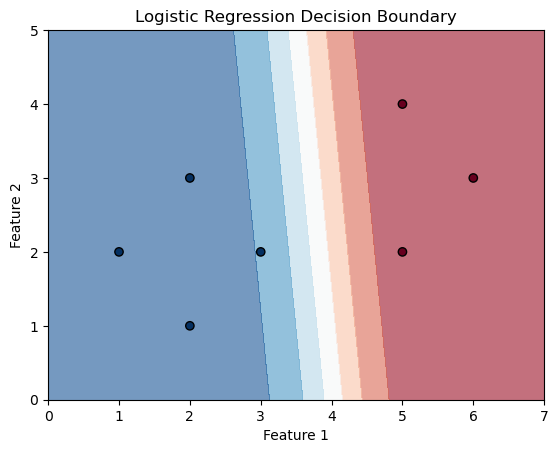

In [171]:
X_bias = column_stack((ones(seven_X.shape[0]), seven_X))

w, weight_trace, _ = lr_train(X_bias, seven_y, eta=0.1, max_iter=5000, alpha=0.01, epsilon=1e-6, trace=True)

print(f"Težine modela: {w}")

error = cross_entropy_error(X_bias, seven_y, w, alpha=0.01)
print(f"Pogreška unakrsne entropije: {error}")

def plot_decision_boundary(X, y, w):
    x1 = linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    x2 = linspace(X[:, 2].min() - 1, X[:, 2].max() + 1, 100)
    x1, x2 = meshgrid(x1, x2)
    X_grid = c_[ones(x1.ravel().shape[0]), x1.ravel(), x2.ravel()]
    y_pred = lr_h(X_grid, w)
    y_pred = y_pred.reshape(x1.shape)
    
    contourf(x1, x2, y_pred, cmap=plt.cm.RdBu, alpha=0.6)
    scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.RdBu, edgecolor='k')
    xlabel('Feature 1')
    ylabel('Feature 2')
    title('Logistic Regression Decision Boundary')
    show()

plot_decision_boundary(X_bias, seven_y, w)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [172]:
from sklearn.metrics import zero_one_loss

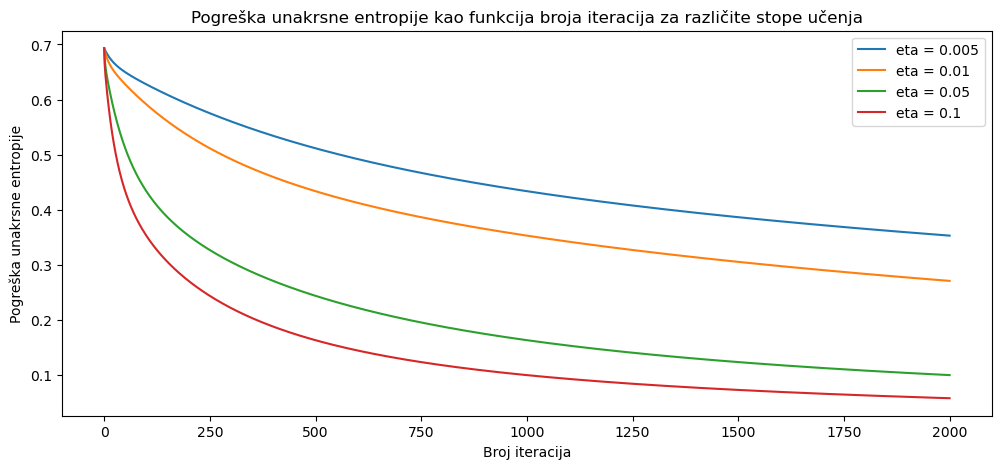

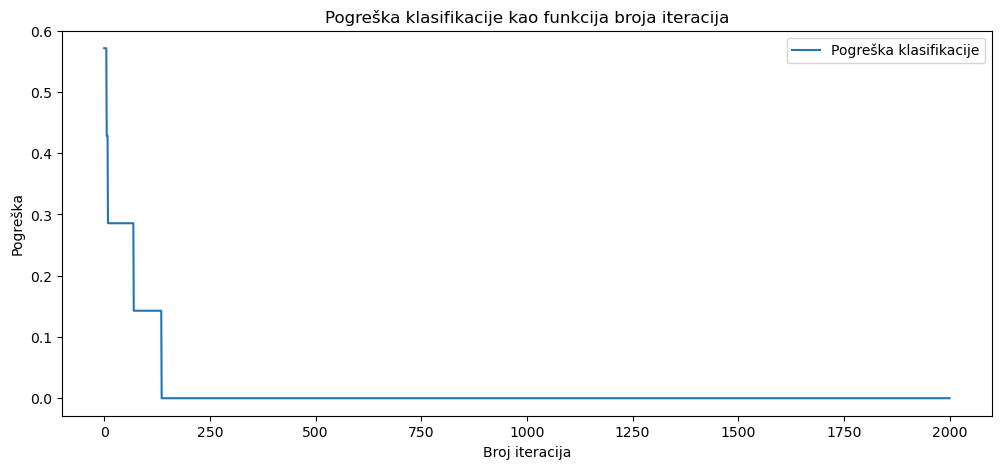

In [173]:
X_bias = np.column_stack((np.ones(seven_X.shape[0]), seven_X))

etas = [0.005, 0.01, 0.05, 0.1]

weight_traces = []
cross_entropy_errors = []

for eta in etas:
    w, weight_trace, _ = lr_train(X_bias, seven_y, eta=eta, max_iter=2000, alpha=0, epsilon=1e-6, trace=True)
    weight_traces.append(weight_trace)
    
    errors = [cross_entropy_error(X_bias, seven_y, w, alpha=0) for w in weight_trace]
    cross_entropy_errors.append(errors)

plt.figure(figsize=(12, 5))
for i, eta in enumerate(etas):
    plot(range(len(cross_entropy_errors[i])), cross_entropy_errors[i], label=f'eta = {eta}')
xlabel('Broj iteracija')
ylabel('Pogreška unakrsne entropije')
title('Pogreška unakrsne entropije kao funkcija broja iteracija za različite stope učenja')
legend()

misclassification_errors = [1 - mean(np.round(lr_h(X_bias, w)) == seven_y) for w in weight_trace]

figure(figsize=(12, 5))
plot(range(len(misclassification_errors)), misclassification_errors, label='Pogreška klasifikacije')
xlabel('Broj iteracija')
ylabel('Pogreška')
title('Pogreška klasifikacije kao funkcija broja iteracija')
legend()
show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

1.0


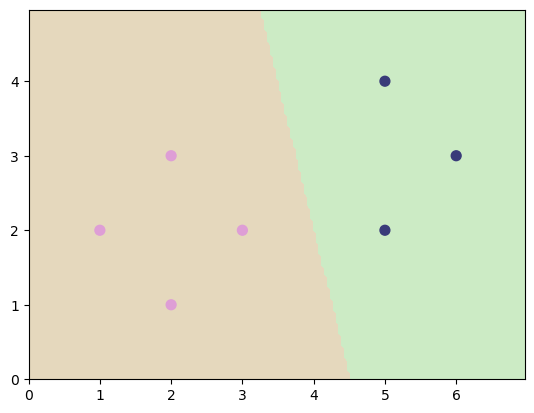

In [186]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter = 100).fit(seven_X, seven_y)
clf.predict(seven_X[:2, :])

print(clf.score(seven_X, seven_y))

h = lambda x: clf.predict(x) >= 0.5
plot_2d_clf_problem(seven_X, seven_y, h = h)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [187]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

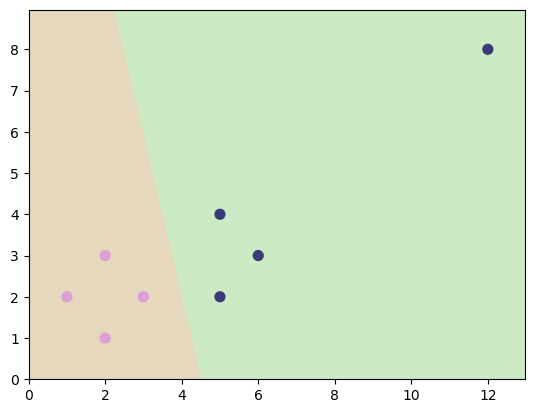

In [188]:
clf = LogisticRegression(random_state=0, max_iter = 100).fit(outlier_X, outlier_y)
clf.predict(outlier_X[:2, :])

clf.predict_proba(outlier_X[:2, :])
clf.score(outlier_X, outlier_y)

h = lambda x: clf.predict(x) >= 0.5
plot_2d_clf_problem(outlier_X, outlier_y, h = h)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

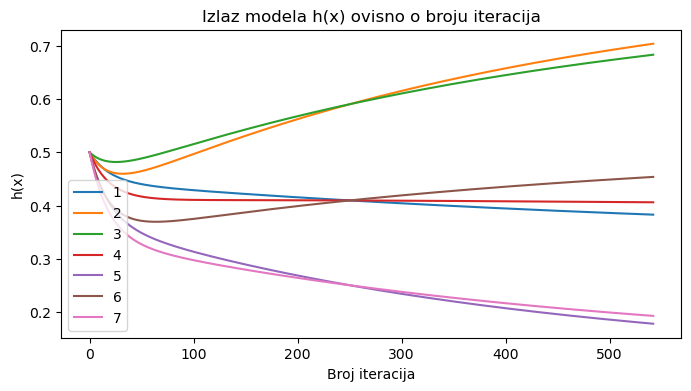

IndexError: index 2 is out of bounds for axis 1 with size 2

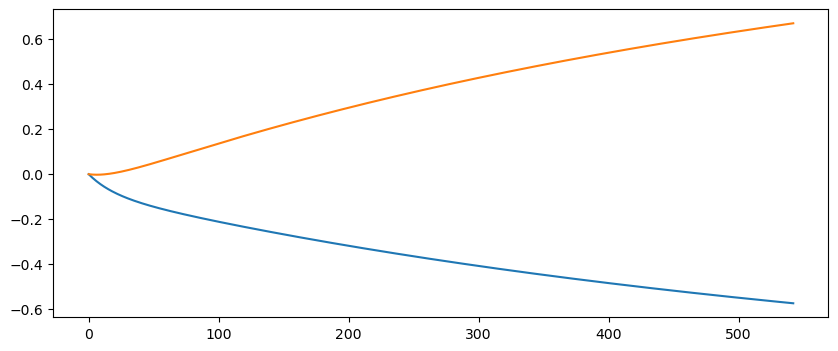

In [189]:
w, w_trace, _ = lr_train(seven_X, seven_y, trace=True)

h_values = array([lr_h(seven_X, wt) for wt in w_trace])
weights = array(w_trace)

figure(figsize=(8, 4))
for i in range(seven_X.shape[0]):
    plot(h_values[:, i], label=f'{i+1}')
xlabel('Broj iteracija')
ylabel('h(x)')
title("Izlaz modela h(x) ovisno o broju iteracija")
legend()
show()

figure(figsize=(10, 4))
plot(weights[:, 0], label='w0')
plot(weights[:, 1], label='w1')
plot(weights[:, 2], label='w2')
xlabel('Broj iteracija')
ylabel('Iznos tezine')
title("Ovisnost iznosa tezine o broju iteracija")
legend()
show()

w0_values = [w[0] for w in w_trace]
w1_values = [w[1] for w in w_trace]
w2_values = [w[2] for w in w_trace]

subplot(1, 2, 2)
plot(range(len(w_trace)), w0_values, label='w0')
plot(range(len(w_trace)), w1_values, label='w1')
plot(range(len(w_trace)), w2_values, label='w2')

xlabel('Broj iteracija')
ylabel('Vrijednosti težina')
title('Vrijednosti težina w0, w1, w2 kroz iteracije')
legend()
grid(True)

tight_layout()
show()


### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [190]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

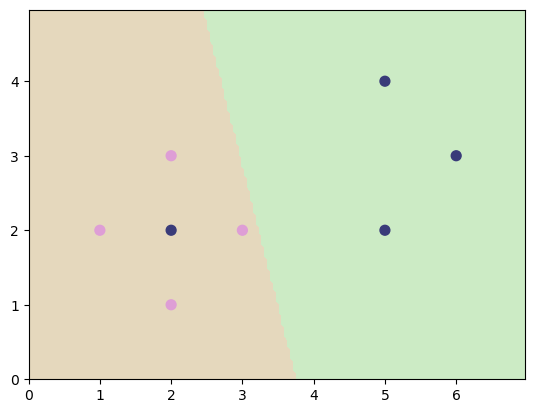

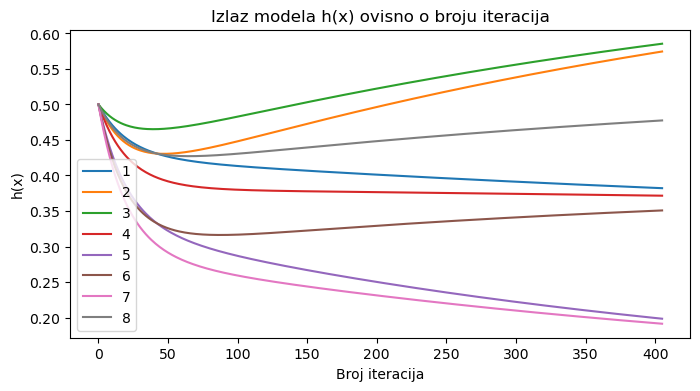

In [191]:
clf = LogisticRegression(random_state=0, max_iter = 100).fit(unsep_X, unsep_y)
clf.predict(unsep_X[:2, :])

clf.predict_proba(unsep_X[:2, :])
clf.score(unsep_X, unsep_y)

h = lambda x: clf.predict(x) >= 0.5
plot_2d_clf_problem(unsep_X, unsep_y, h = h)

w, w_trace, _ = lr_train(unsep_X, unsep_y, trace=True)

h_values = array([lr_h(unsep_X, wt) for wt in w_trace])
weights = array(w_trace)

figure(figsize=(8, 4))
for i in range(unsep_X.shape[0]):
    plot(h_values[:, i], label=f'{i+1}')
xlabel('Broj iteracija')
ylabel('h(x)')
title("Izlaz modela h(x) ovisno o broju iteracija")
legend()
show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [192]:
from numpy.linalg import norm

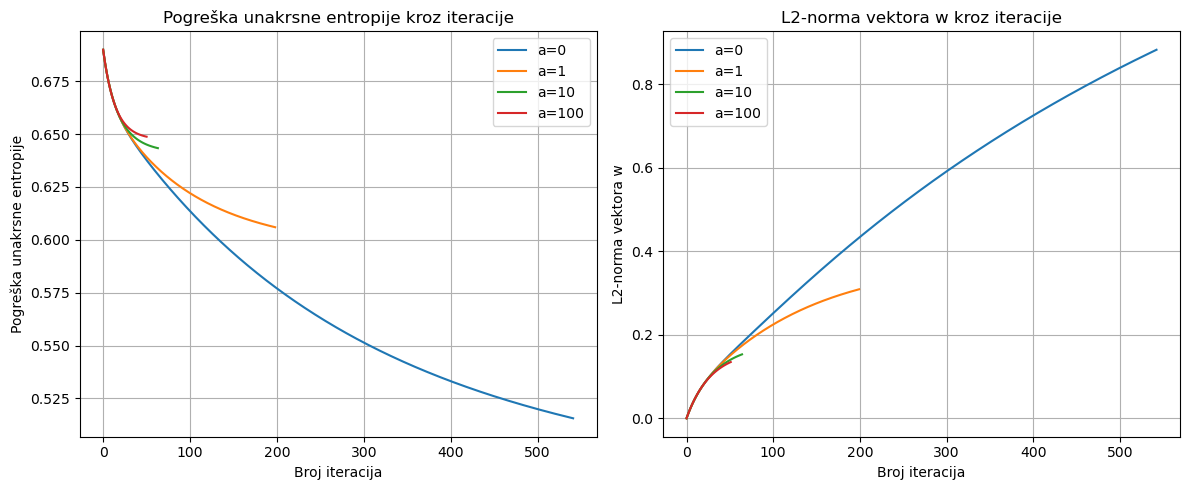

In [193]:
alphas = [0, 1, 10, 100]

figure(figsize=(12, 5))

for alpha in alphas:
    w, w_trace, errors = lr_train(seven_X, seven_y, alpha=alpha, trace=True)

    subplot(1, 2, 1)
    plot(range(len(errors)), errors, label=f'a={alpha}')
    
    w_norms = []
    for example in w_trace:
        w_norms.append(norm(example))
    subplot(1, 2, 2)
    plot(range(len(w_norms)), w_norms, label=f'a={alpha}')

subplot(1, 2, 1)
xlabel('Broj iteracija')
ylabel('Pogreška unakrsne entropije')
title('Pogreška unakrsne entropije kroz iteracije')
legend()
grid(True)

subplot(1, 2, 2)
xlabel('Broj iteracija')
ylabel('L2-norma vektora w')
title('L2-norma vektora w kroz iteracije')
legend()
grid(True)

tight_layout()
show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [194]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

Točnost modela stupnja 2: 0.94
Točnost modela stupnja 3: 0.9566666666666667


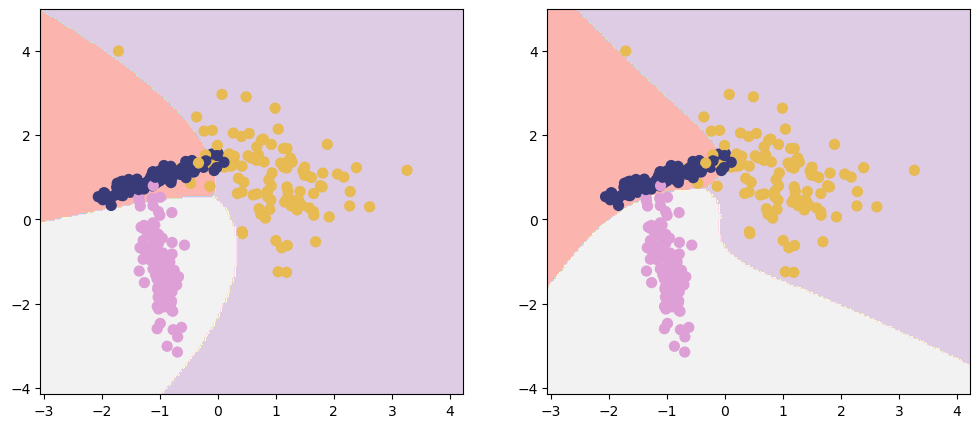

In [195]:
from sklearn.datasets import make_classification

p1 = PolynomialFeatures(degree=2)
X_p1 = p1.fit_transform(X)

model2 = LogisticRegression().fit(X_p1, y)

figure(figsize=(12, 5))
subplot(1, 2, 1)
plot_2d_clf_problem(X, y, lambda x: model2.predict(p1.transform(x)))

p2 = PolynomialFeatures(degree=3)
X_p2 = p2.fit_transform(X)

model3 = LogisticRegression().fit(X_p2, y)

subplot(1, 2, 2)
plot_2d_clf_problem(X, y, lambda x: model3.predict(p2.transform(x)))

pred_y2 = model2.predict(p1.transform(X))
accuracy2 = accuracy_score(y, pred_y2)
print(f'Točnost modela stupnja 2: {accuracy2}')

pred_y3 = model3.predict(p2.transform(X))
accuracy3 = accuracy_score(y, pred_y3)
print(f'Točnost modela stupnja 3: {accuracy3}')

show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?